# Example code for visualizing, results

## Setup

In [1]:
from glob import glob
import numpy as np
import scipy as sp
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

if os.path.split(os.getcwd())[-1] != 'structure-from-sound-python':
    os.chdir("../")

from src.detectors import gcc_phat_detector
from src.tdoa_matrix_to_tdoa_vector import tdoa_matrix_to_tdoa_vector
from src import tdoa_datasets_module

# import importlib
# importlib.reload(tdoa_datasets_module)
import system_settings

## Config

In [2]:
dataset_name = "tdoa_20201016"
#experiment_name = "chirp_0004"

#experiment_name = "music_0015"

experiment_name = "music_0015"
#experiment_name = "singing_0016"
#experiment_name = "metronom_0021"

approx_room_size = 10  # meters

data_folder = os.path.join(".", "data", dataset_name, "data", experiment_name)
result_folder = os.path.join(
    ".", "results", system_settings.system_name, dataset_name, "data", experiment_name)


In [3]:
import pandas as pd

a = pd.array([1,2,3])
a[0]
a[0:1]

<IntegerArray>
[1]
Length: 1, dtype: Int64

In [4]:
import torch

a = torch.ones(3,2,5)*2
b = torch.ones(3,5,3)*2
a@b

tensor([[[20., 20., 20.],
         [20., 20., 20.]],

        [[20., 20., 20.],
         [20., 20., 20.]],

        [[20., 20., 20.],
         [20., 20., 20.]]])

## Detection comparision

Text(0, 0.5, 'distance difference (meters)')

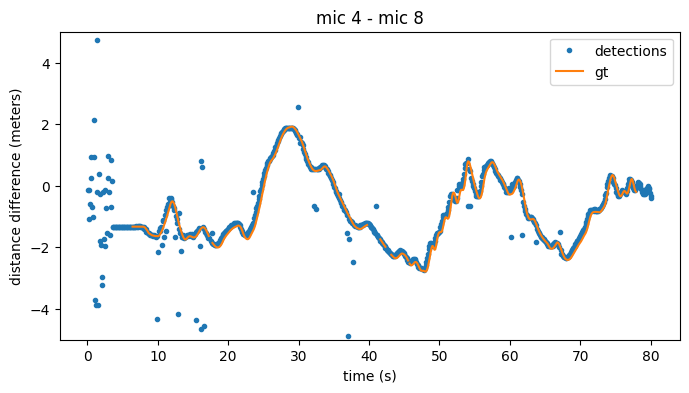

In [5]:
detections, tdoa_gt, detection_times = tdoa_datasets_module.get_detections_with_gt(
    data_folder, result_folder)
# speaker_gt_pos.shape

plt.figure(figsize=(8, 4))
mic1, mic2 = np.random.permutation(detections.shape[1])[:2]
# mic2 = 2


plt.plot(detection_times, detections[:, mic1, mic2], '.')
plt.plot(detection_times, tdoa_gt[:, mic1, mic2])
plt.title(f'mic {mic2} - mic {mic1}')
plt.legend(["detections", "gt"])
plt.ylim(-approx_room_size/2, approx_room_size/2)
plt.xlabel("time (s)")
plt.ylabel("distance difference (meters)")

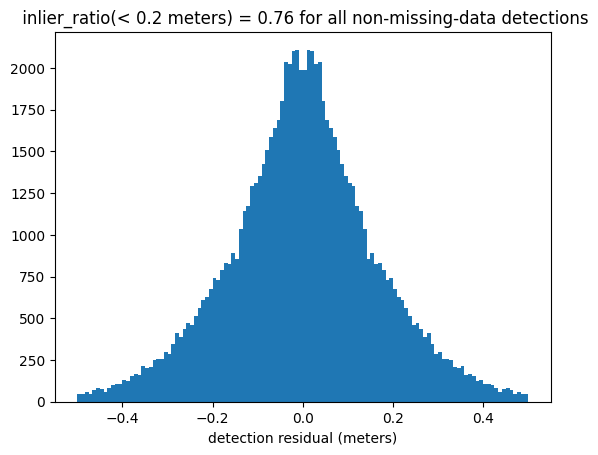

In [6]:
res = detections - tdoa_gt
res = res[np.logical_not(np.isnan(res))]
tol = 0.2

plt.hist(res[abs(res) < 0.5], 120)

plt.title(
    f' inlier_ratio(< {tol} meters) = {sum(abs(res) < tol)/np.size(res):.2f} for all non-missing-data detections')
plt.xlabel("detection residual (meters)")
pass


## Tdoa-vector comparision

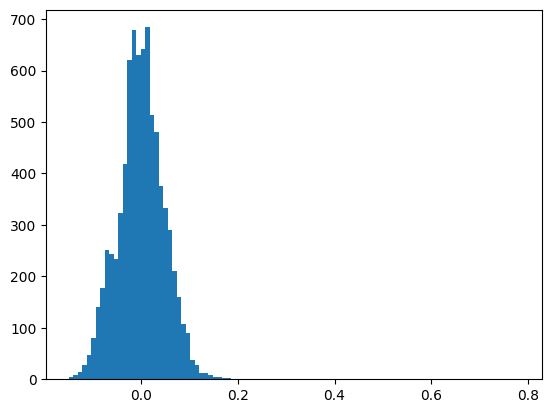

In [7]:
tdoav = np.load(os.path.join(result_folder,"tdoa_vectors.npy")) # load estimation

receiver_positions, sender_positions, receiver_gt_positions, sender_gt_positions = tdoa_datasets_module.get_positions_with_gt(data_folder,result_folder)
tdoav_gt = sp.spatial.distance.cdist(sender_gt_positions,receiver_gt_positions)
def sync_tdoa_to_gt(tdoav, tdoav_gt, tol =0.2):
    re_tdoav = np.zeros(tdoav.shape)
    for i in range(tdoav.shape[0]):
        t = tdoav[i]
        tgt = tdoav_gt[i]
        
        most_inliers = -1
        for j in range(t.shape[0]):
            offset = tgt[j] - t[j]
            res = t + offset - tgt
            inliers = np.abs(res) < tol
            if np.sum(inliers) > most_inliers:
                best_inliers = inliers
                most_inliers = np.sum(inliers)
                best_offset = offset
        A = np.ones((most_inliers,1))
        b = tgt[best_inliers] - t[best_inliers]    
        best_offset = np.linalg.lstsq(A,b,rcond=None)
        re_tdoav[i] = t + best_offset[0]
    return re_tdoav

synced_tdoav = sync_tdoa_to_gt(tdoav, tdoav_gt)
res = np.ndarray.flatten((synced_tdoav - tdoav_gt))
plt.hist(res[np.abs(res) < 1],100);


## Position-comparison

In [8]:
a = "was"
b = a


(736, 3)
(736, 3)
0.1124546857400113


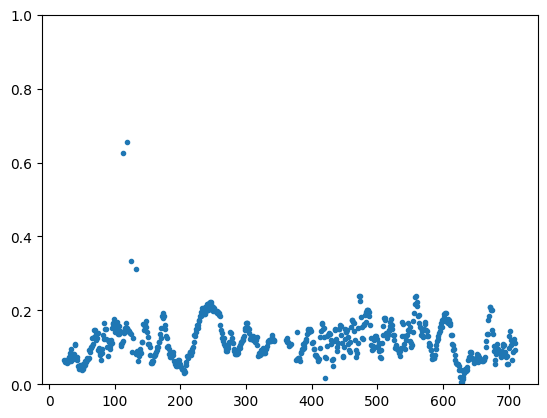

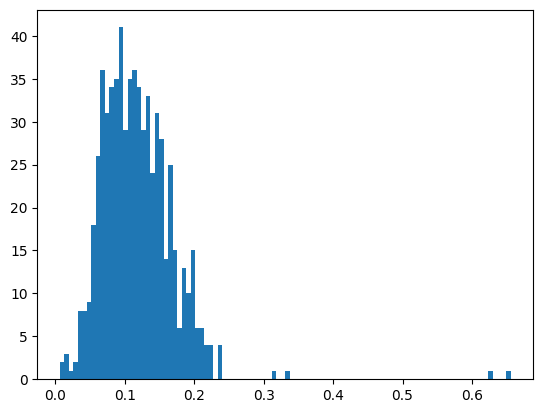

In [9]:
receiver_positions, sender_positions, receiver_gt_positions, sender_gt_positions = tdoa_datasets_module.get_positions_with_gt(
    data_folder, result_folder)

print(sender_gt_positions.shape)
print(sender_positions.shape)
res = np.linalg.norm(sender_gt_positions - sender_positions, axis=1)
res = np.linalg.norm(np.roll(sender_gt_positions,-2,axis=0) - sender_positions, axis=1) # we have incorrect time sync? Much better results at 2 positions earilier? so 0.2 s off?

plt.figure()
plt.plot(res, '.')
plt.ylim(0, 1)

plt.figure()
plt.hist(res[res < 1], 100)
print(np.median(res[res < 1]))
pass



In [10]:
np.load("/Users/eriktegler/structure-from-sound-python/results/Baseline/tdoa_20201016/data/iregchirp_0007/tdoa_vectors.npy").shape
#np.load("/Users/eriktegler/structure-from-sound-python/results/Baseline/tdoa_20201016/data/iregchirp_0006/sender_positions.npy").shape
a = pd.read_csv("/Users/eriktegler/structure-from-sound-python/results/Baseline/tdoa_20201016/data/iregchirp_0006/sender_positions.csv", header=None).to_numpy()

a[0:5,0:5]

#pd.read_csv("/Users/eriktegler/structure-from-sound-python/data/tdoa_20201016/data/iregchirp_0006/gt_positions.csv", header=None).to_numpy().shape


array([[-4313.72214022,  -153.90191736,   122.24431369,   172.91250146,
         -225.86205787],
       [-3611.23425297,  1558.00906176, -1194.31447773, -1833.69612356,
         2067.26353782],
       [ 2473.18543071,  -416.46718619,   375.80718063,   563.16677621,
         -553.08979455]])

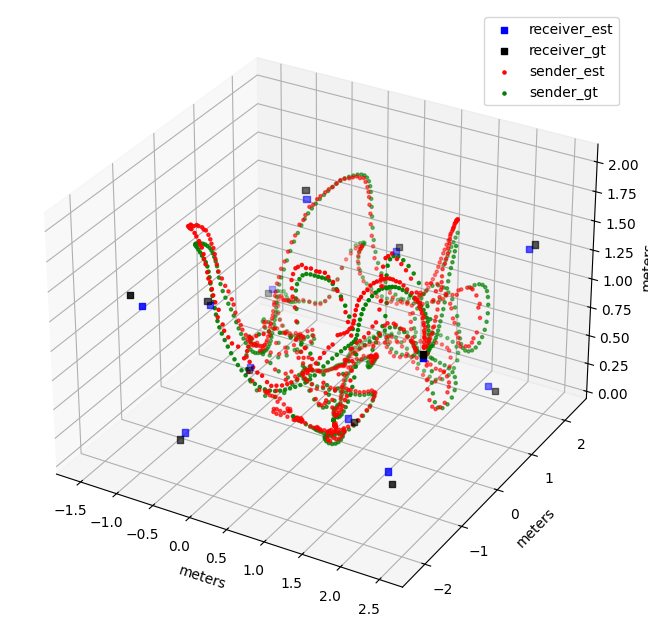

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')


ax.scatter(receiver_positions[:, 0],
           receiver_positions[:, 1], receiver_positions[:, 2], c='b', marker="s")
ax.scatter(receiver_gt_positions[:, 0],
           receiver_gt_positions[:, 1], receiver_gt_positions[:, 2], c='k', marker="s")


reasonable_ind = np.all(np.logical_and(
    sender_positions < approx_room_size, sender_positions > -approx_room_size), axis=1)
ax.scatter(sender_positions[reasonable_ind, 0],
           sender_positions[reasonable_ind, 1], sender_positions[reasonable_ind, 2], c='r', marker=".")
ax.scatter(sender_gt_positions[:, 0], sender_gt_positions[:, 1],
           sender_gt_positions[:, 2], c='g', marker=".")
ax.legend(["receiver_est", "receiver_gt", "sender_est", "sender_gt"])

ax.set_xlabel('meters')
ax.set_ylabel('meters')
ax.set_zlabel('meters')
pass
plt.savefig("3d_plot.png",dpi=500)

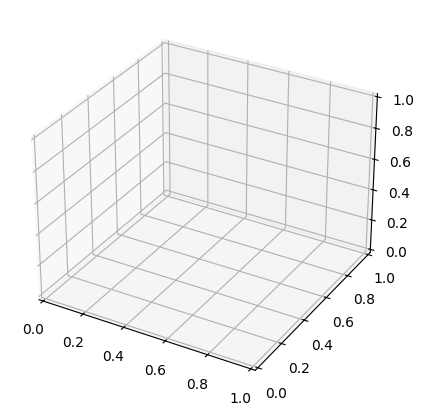

ValueError: unknown file extension: .m4a

In [12]:
from matplotlib.animation import FuncAnimation
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')


def f(x):
    
    ax.cla()
    ax.scatter(receiver_positions[:, 0],
               receiver_positions[:, 1], receiver_positions[:, 2], c='b', marker="s")
    ax.scatter(receiver_gt_positions[:, 0],
               receiver_gt_positions[:, 1], receiver_gt_positions[:, 2], c='k', marker="s")

    reasonable_ind = np.all(np.logical_and(
        sender_positions < approx_room_size, sender_positions > -approx_room_size), axis=1)

    width = 30
    xmin = np.max([0, int(x)-width])
    xmax = np.min([len(sender_positions[reasonable_ind, 1]), x + width])

    index_to_plot = np.arange(xmin, xmax)

    ax.scatter(sender_positions[reasonable_ind, 0][index_to_plot],
               sender_positions[reasonable_ind, 1][index_to_plot], sender_positions[reasonable_ind, 2][index_to_plot], c='r', marker=".",s=[500 if i == len(index_to_plot)-1 else 10 for i in range(len(index_to_plot))])
    #ax.scatter(sender_positions[reasonable_ind, 0][index_to_plot],
    #           sender_positions[reasonable_ind, 1][index_to_plot], sender_positions[reasonable_ind, 2][index_to_plot], c='r', marker=".", s=[50 for i in range(len(index_to_plot))])
    #ax.scatter(sender_positions[reasonable_ind, 0][index_to_plot],
    #           sender_positions[reasonable_ind, 1][index_to_plot], sender_positions[reasonable_ind, 2][index_to_plot], c='r', marker=".", MarkerSize=300)

    ax.scatter(sender_gt_positions[index_to_plot, 0], sender_gt_positions[index_to_plot, 1],
               sender_gt_positions[index_to_plot, 2], c='g', marker=".")
    
    ax.legend(["receiver_est", "receiver_gt", "sender_est", "sender_gt"])

    ax.set_xlabel('meters')
    ax.set_ylabel('meters')
    ax.set_zlabel('meters')
    ax.set_zlim(0,2)
    ax.set_xlim(-2,3)
    ax.set_ylim(-3,3)

animation = FuncAnimation(fig,
    func = f,
    frames = np.arange(0, 716, 2), 
    interval = 40)
plt.show()
animation.save(filename="test_animation.m4a",writer="pillow")


In [ ]:
animation.save(filename="test_animation.mp4",writer="ffmpeg")

In [ ]:
%matplotlib inline

interactive(children=(IntSlider(value=0, description='x', max=716), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

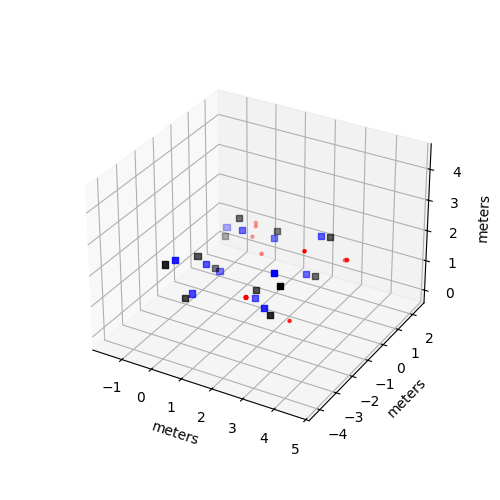

In [13]:
from ipywidgets import widgets
from ipywidgets import interact
%matplotlib widget

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')


def f(x):

    ax.cla()
    ax.scatter(receiver_positions[:, 0],
               receiver_positions[:, 1], receiver_positions[:, 2], c='b', marker="s")
    ax.scatter(receiver_gt_positions[:, 0],
               receiver_gt_positions[:, 1], receiver_gt_positions[:, 2], c='k', marker="s")

    reasonable_ind = np.all(np.logical_and(
        sender_positions < approx_room_size, sender_positions > -approx_room_size), axis=1)

    width = 30
    xmin = np.max([0, int(x)-width])
    xmax = np.min([len(sender_positions[reasonable_ind, 1]), x + width])

    index_to_plot = np.arange(xmin, xmax)

    ax.scatter(sender_positions[reasonable_ind, 0][index_to_plot],
               sender_positions[reasonable_ind, 1][index_to_plot], sender_positions[reasonable_ind, 2][index_to_plot], c='r', marker=".")
    ax.scatter(sender_gt_positions[index_to_plot, 0], sender_gt_positions[index_to_plot, 1],
               sender_gt_positions[index_to_plot, 2], c='g', marker=".")
    # ax.legend(["receiver_est", "receiver_gt", "sender_est", "sender_gt"])

    ax.set_xlabel('meters')
    ax.set_ylabel('meters')
    ax.set_zlabel('meters')


interact(f, x=widgets.IntSlider(min=0, max=len(
    sender_positions[reasonable_ind, 1]), step=1, value=0))
